[View in Colaboratory](https://colab.research.google.com/github/olegtaratuhin/soy_modeling/blob/master/soya_modeling.ipynb)

# Soy blossom period prediction model

## Setup

### Configure environment

In [97]:
!pip install pydot

### Show the machine details the environment is running on

Show CPU info

In [3]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm pti fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) 

Show RAM info

In [4]:
!cat /proc/meminfo

MemTotal:       13335204 kB
MemFree:         6664408 kB
MemAvailable:   12631916 kB
Buffers:           51612 kB
Cached:          6080724 kB
SwapCached:            0 kB
Active:           732944 kB
Inactive:        5683300 kB
Active(anon):     262336 kB
Inactive(anon):      332 kB
Active(file):     470608 kB
Inactive(file):  5682968 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               816 kB
Writeback:             0 kB
AnonPages:        284000 kB
Mapped:           160996 kB
Shmem:               836 kB
Slab:             142488 kB
SReclaimable:     111356 kB
SUnreclaim:        31132 kB
KernelStack:        3704 kB
PageTables:         4556 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667600 kB
Committed_AS:    1673456 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

Show GPU info

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10935837883317672325, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13877073830548924300
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

### Import modules

In [0]:
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score as r2_metric

In [0]:
from keras import backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Set up the dataset

Download a dataset from shared Drive folder. 

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1lLemPuEQkL1-OQCPrSbYyMLFAwVlcpyD'})
downloaded.GetContentFile('soydata.csv')

Import data set into pandas dataframe. The dataset contains a missing value on one of the key features the model will be training with, so we need to remove that explicitly

In [0]:
df = pd.read_csv('soydata.csv', index_col=[0, 1])
df.dropna()

The data in now loaded, it uses format that will be described somewhere here some day. 

### Feature extraction

Shuffle the data. As dataset uses multiindex that is a little tricky, we need to shuffle only the certain level, but the days inside a single experiment shall be in natural order.

In [0]:
shuffled_indexes = [i for i in range(len(df.index.levels[0]))]
random.shuffle(shuffled_indexes)
new_indexes = sorted(df.index, key=lambda x: shuffled_indexes.index(x[0]))

In [0]:
df = df.reindex(new_indexes)

In [0]:
df

Select features and target parameter. As the data is shuffled at this point we no longer need multi-index, and selecting values will truncate that information automatically.

In [0]:
features = ['t_min', 't_max', 'dlen', 'day']
data = df[features].values
target = df['state'].values

data is numpy matrix with only the needed features for the model and target is numpy vector with output data

In [40]:
#@title Select number of rows to display { run: "auto", form-width: "30%" }
num_entries = 3 #@param {type:"slider", min:0, max:5, step:1}
print("Data:  ", data.shape, "Showing only", num_entries, "\n", data[0:num_entries], "\n")
print("Target:", target.shape, "Showing only", num_entries, "\n", target[0:num_entries], "\n")

Data:   (6134, 4) Showing only 3 
 [[0.02       0.04875    0.05563903 0.        ]
 [0.04625    0.0625     0.11205787 0.01960784]
 [0.04625    0.0625     0.1692365  0.03921569]] 

Target: (6134,) Showing only 3 
 [0.00669285 0.00797427 0.00949868] 



Split the data for training and testing

In [173]:
#@title Set the desired partition of test and train samples { run: "auto", form-width: "30%", display-mode: "both" }
border = 6100 #@param {type:"slider", min:4000, max:6100, step:30}
train_input, train_output = data[:border], target[:border]
test_input, test_output = data[border:], target[border:]

print("Train set contains", len(train_input))
print("Test set contains", len(test_input))

Train set contains 6100
Test set contains 34


##  Model

We will use a simple model with input layer of 4 neurons, a single hidden layer with 20 neurons and 1 output neuron

In [0]:
tf.enable_eager_execution()

### Keras model definition

In [0]:
model = keras.Sequential()
model.add(keras.layers.Dense(20, input_dim=4, activation=tf.nn.sigmoid))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

### Keras model compile

In [0]:
model.compile(loss='mse',
              optimizer=tf.train.GradientDescentOptimizer(learning_rate=10.),
              metrics=['mse', 'mae', r2])

Model summary shows the architecture of the keras model

In [191]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                100       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
None


## Results

In [208]:
#@title Hyperparameters { run: "auto", form-width: "30%" }
epochs = 40 #@param {type:"integer"}
history = model.fit(
    train_input, train_output,
    epochs=epochs,
    verbose=1,
    batch_size=35,
    validation_split=0.25)

Epoch 1/40
131/131 [==============================] - 2s 12ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0130 - r2: 0.9882 - val_loss: 4.5630e-04 - val_mean_squared_error: 4.5630e-04 - val_mean_absolute_error: 0.0140 - val_r2: 0.9963
Epoch 2/40
131/131 [==============================] - 2s 12ms/step - loss: 3.1636e-04 - mean_squared_error: 3.1636e-04 - mean_absolute_error: 0.0107 - r2: 0.9974 - val_loss: 2.7469e-05 - val_mean_squared_error: 2.7469e-05 - val_mean_absolute_error: 0.0042 - val_r2: 0.9998
Epoch 3/40
131/131 [==============================] - 2s 12ms/step - loss: 7.1786e-05 - mean_squared_error: 7.1786e-05 - mean_absolute_error: 0.0050 - r2: 0.9995 - val_loss: 1.9610e-05 - val_mean_squared_error: 1.9610e-05 - val_mean_absolute_error: 0.0034 - val_r2: 0.9999
Epoch 4/40
131/131 [==============================] - 2s 12ms/step - loss: 4.8888e-05 - mean_squared_error: 4.8888e-05 - mean_absolute_error: 0.0048 - r2: 0.9996 - val_loss: 1.8623e-05 - va

In [209]:
loss, mse, mae, r2_value = model.evaluate(test_input, test_output)

print("MSE: ", mse)
print("MAE: ", mae)
print("R2:  ", r2_value)
print("Loss:", loss)

2/2 [==============================] - 0s 11ms/step
MSE:  7.700732700922185e-07
MAE:  0.0007674317149554982
R2:   0.9616656618959764
Loss: 7.700732700922185e-07


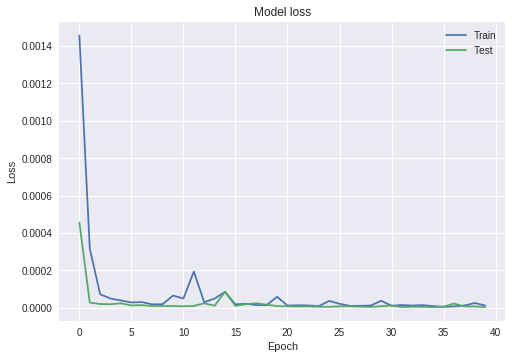

In [211]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Conclusion

The model passed proof of concept phase, it does learn and gives OK prediction, more data will lead to even more accurate results.